#### Hi
this will be a CIFAR10 using VGG16 (pre trained model)  
My model (hand made) (the previous one) had 82.2% of accuracy.   
Lets see how this VGG16 will do  

2023/01/30 2027i let get init  

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models

In [2]:
##Hardware
import torch
if torch.cuda.is_available() == True:
  device = 'cuda'
  templist = [1,2,3]
  templist = torch.FloatTensor(templist).to(device)
  print("Cuda torch working : ",end="")
  print(templist.is_cuda)
  print("current device no. : ",end="")
  print(torch.cuda.current_device())
  print("GPU device count : ",end="")
  print(torch.cuda.device_count())
  print("GPU name : ",end="")
  print(torch.cuda.get_device_name(0))
  print("device : ",device)
  ! nvidia-smi
elif torch.backends.mps.is_available() == True:
  print("Apple device detected\nActivating Apple Silicon GPU")
  device = torch.device("mps")
else:
  print("cant use gpu , activating cpu")
  device = 'cpu'

Cuda torch working : True
current device no. : 0
GPU device count : 1
GPU name : NVIDIA GeForce GTX 1080
device :  cuda
Tue Jan 31 01:20:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 42%   31C    P2    43W / 180W |   7957MiB /  8192MiB |     22%      Default |
|                               |                      |                  N/A |
+-------------------------------+---------------

#### Data
since the VGG16 uses 224 x 224 model and CIFAR10 is 32x32 we have to change the CIFAR10 size to 224x224  

In [3]:
num_subprocesses = 8 ###CHANGE (REDUCE) VALUE IF ERROR###
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                        shuffle=True, num_workers=num_subprocesses)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                        shuffle=False, num_workers=num_subprocesses)


Files already downloaded and verified
Files already downloaded and verified


#### VGG
I will use the predtrained vgg  
The default out features of vgg16 is 1000. But we need only one.  
So we will need line no 5. to change the out features to 10  
And since we will not change the parameters we will not require grad  
  


In [4]:
vgg16 = models.vgg16(pretrained=True)
vgg16.to(device)

# change the number of classes 
vgg16.classifier[6].out_features = 10

# freeze convolution weights
# BUT convolutional layers WILL learn // allowing the model to focus on learning the mapping between the extracted features and the output predictions
for param in vgg16.features.parameters():
    param.requires_grad = False

print(vgg16)

c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### LOSS and Optim


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)

In [6]:
#validation function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    
    return val_loss, val_accuracy

In [7]:
# training function
def train(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)

    #print('Train Loss: %.4f'%train_loss)
    
    return train_loss, train_accuracy

In [8]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(10):
    train_epoch_loss, train_epoch_accuracy = train(vgg16, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(vgg16, testloader)
    print("Train Loss : %f/  Train Acc : %.2f/  Val Loss : %f/  Val Acc : %.2f"%(train_epoch_loss,train_epoch_accuracy,val_epoch_loss,val_epoch_accuracy))
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

    #print("Train Acc : %f"%train_accuracy,"Val Acc : %f"%val_accuracy)
    
end = time.time()

print(int((end-start)//60), 'minutes', int((end-start)%60), 'seconds')

Train Loss : 0.025621/  Train Acc : 73.43/  Val Loss : 0.015502/  Val Acc : 82.56
Train Loss : 0.014776/  Train Acc : 83.62/  Val Loss : 0.013831/  Val Acc : 84.69
Train Loss : 0.011731/  Train Acc : 86.77/  Val Loss : 0.012940/  Val Acc : 85.80
Train Loss : 0.009391/  Train Acc : 89.48/  Val Loss : 0.012371/  Val Acc : 86.72
Train Loss : 0.007482/  Train Acc : 91.67/  Val Loss : 0.012376/  Val Acc : 86.96
Train Loss : 0.005794/  Train Acc : 93.53/  Val Loss : 0.012809/  Val Acc : 87.28
Train Loss : 0.004342/  Train Acc : 95.20/  Val Loss : 0.012660/  Val Acc : 87.59
Train Loss : 0.003155/  Train Acc : 96.71/  Val Loss : 0.013327/  Val Acc : 87.31
Train Loss : 0.002377/  Train Acc : 97.57/  Val Loss : 0.013791/  Val Acc : 87.53
Train Loss : 0.001749/  Train Acc : 98.30/  Val Loss : 0.014177/  Val Acc : 87.78
61 minutes 32 seconds


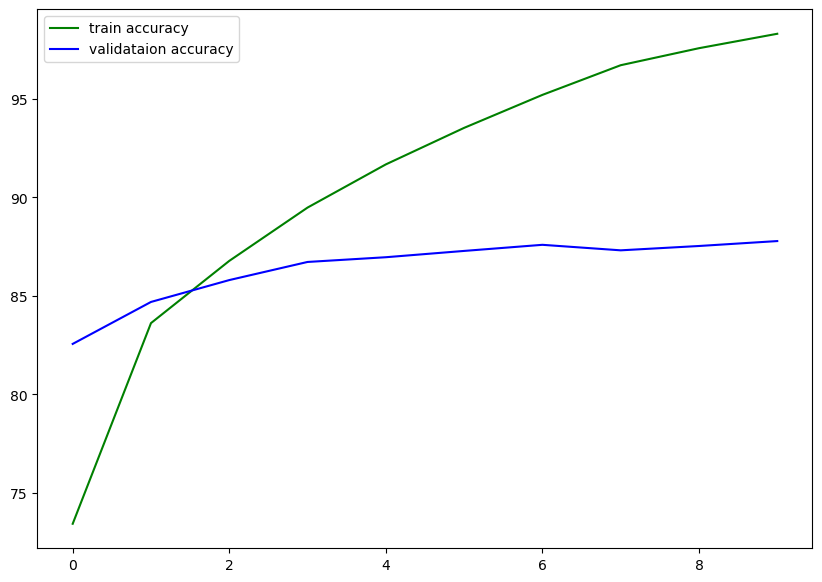

In [9]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

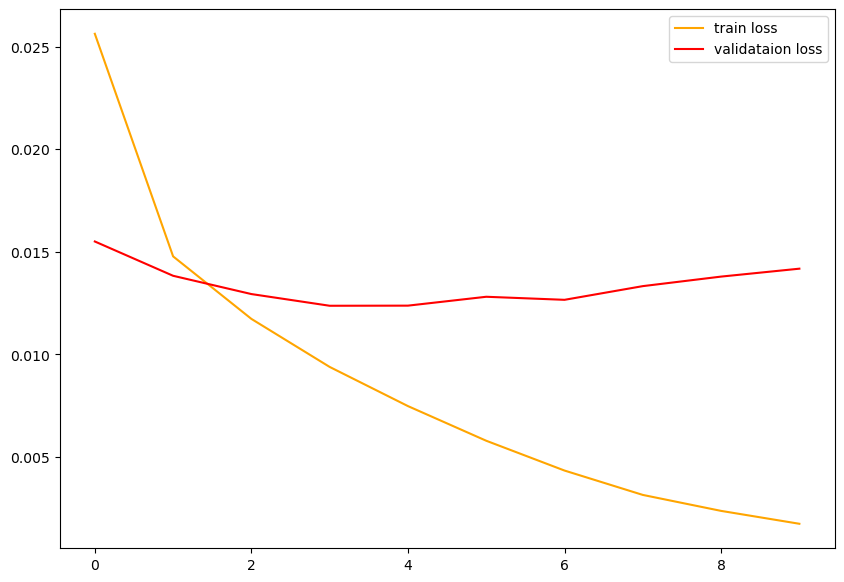

In [10]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()